### Import

In [1]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from read import read_datasets, get_subsets
datasets = read_datasets()
list(datasets.keys())

['oversampled_normalized',
 'undersampled_normalized',
 'undersampled',
 'oversampled',
 'normalClass',
 'normalClass_normalized']

### Linear Regression

#### Define functions for running linear regression tests

In [3]:
from sklearn.linear_model import LinearRegression
def run_linearRegression(dataset_name, subset = []):
    assert dataset_name in datasets

    X_train, X_test, y_train, y_test = get_subsets(datasets[dataset_name])
    
    if subset:
        assert any(c in X_train.columns for c in subset)
        X_train = X_train[[c for c in subset if c in X_train.columns]]
        X_test = X_test[[c for c in subset if c in X_test.columns]]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    coefficients = pd.DataFrame({
        "variable":["INTERCEPT"] + list(X_train.columns),
        "coefficient":[model.intercept_] + list(model.coef_)
    })


    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return coefficients, y_test, y_pred, mse, r2

In [4]:
def test_diff_datasets(subset = []):
    results = {
        "dataName":[name for name in datasets],
        "featureSubset":["_".join(subset) for name in datasets],
        "mse":[],
        "r2":[]
    }
    for name in datasets:
        _, _, _, mse, r2 = run_linearRegression(name, subset)
        results["mse"].append(mse)
        results["r2"].append(r2)
    
    return pd.DataFrame(results).sort_values(by = "mse").reset_index(drop = True)

In [5]:
def getCombos(dataName, drop = []):
    X_train, _, _, _ = get_subsets(datasets[dataName])

    cols = list(X_train.columns)
    if drop:
        cols = [c for c in cols if c not in drop]
    assert cols

    combos = []
    for i in range(1, len(cols) + 1):
        combos.extend(combinations(cols, i))
    
    return combos

#### Test All Feature Subsets

In [6]:
dfOut = pd.DataFrame
for combo in tqdm(getCombos("normalClass"), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut.empty:
        dfOut = result
    else:
        dfOut = pd.concat([dfOut, result])

Subset Testing:   0%|          | 0/2047 [00:00<?, ?it/s]

Subset Testing: 100%|██████████| 2047/2047 [01:27<00:00, 23.43it/s]


In [7]:
bestPerDataName = dfOut.groupby('dataName', as_index=False).apply(lambda x: x.nsmallest(1, columns='mse')).reset_index(drop = True)
bestPerDataName

,dataName,featureSubset,mse,r2
0,normalClass,fixed acidity_volatile acidity_residual sugar_...,0.375114,0.340628
1,normalClass_normalized,fixed acidity_volatile acidity_residual sugar_...,0.379095,0.333631
2,oversampled,fixed acidity_volatile acidity_citric acid_res...,0.948022,0.670136
3,oversampled_normalized,fixed acidity_volatile acidity_citric acid_res...,0.955661,0.667478
4,undersampled,fixed acidity_volatile acidity_residual sugar_...,0.386782,0.791398
5,undersampled_normalized,volatile acidity_residual sugar_free sulfur di...,1.310850,0.293025


#### Manually Remove Collinearity

In [8]:
dropCols = ["free sulfur dioxide", "pH", "sulfur", "citric acid", "volatile acidity"]

dfOut_subset = pd.DataFrame
for combo in tqdm(getCombos("normalClass", dropCols), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut_subset.empty:
        dfOut_subset = result
    else:
        dfOut_subset = pd.concat([dfOut_subset, result])

Subset Testing: 100%|██████████| 127/127 [00:06<00:00, 20.36it/s]


In [9]:
bestPerDataName_subset = dfOut_subset.groupby('dataName', as_index=False).apply(lambda x: x.nsmallest(1, columns='mse')).reset_index(drop = True)
bestPerDataName_subset.to_csv("RegressionOutput/linearRegression.csv", index = False)
bestPerDataName_subset

,dataName,featureSubset,mse,r2
0,normalClass,fixed acidity_residual sugar_chlorides_total s...,0.402354,0.292747
1,normalClass_normalized,fixed acidity_residual sugar_chlorides_total s...,0.409020,0.281028
2,oversampled,fixed acidity_chlorides_density_sulphates_alcohol,1.246872,0.566152
3,oversampled_normalized,fixed acidity_chlorides_density_sulphates_alcohol,1.254024,0.563663
4,undersampled,fixed acidity_chlorides_sulphates_alcohol,1.090288,0.411980
5,undersampled_normalized,fixed acidity_chlorides_sulphates_alcohol,1.653670,0.108133


### Read in R Data

In [1]:
library(ISLR)
library(gam)
library(splines)
library(tidyverse)
library(caret)
library(dplyr)
library(nnet)

Warning message:
"package 'gam' was built under R version 4.1.2"


Loading required package: splines

Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.1.2"
Loaded gam 1.22-2


Warning message:
"package 'tidyverse' was built under R version 4.1.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.2.0     v stringr 1.5.0
v readr   2.1.2     v forcats 0.5.2
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'purrr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
Warning message:
"package 'stringr' was built under R version 4.1.2"
Warning message:
"package 'forcats' was built under R version 4.1.2"
--

In [2]:
files <- c()
dfs <- list()
for(file in list.files("data/")){
    if(file != "winequality.csv"){
        files <- append(files, strsplit(file, "\\.")[[1]][1])
        dfs <- append(dfs, list(read.csv(paste("data/",file,sep = ""), header = T)))
    }
}

In [3]:
getSplit <- function(df, train_or_test){
    retDf <- subset(df, train_test == train_or_test)
    retDf$train_test <- NULL
    return (retDf)
}

train_dfs <- list()
test_dfs <- list()
for(df in dfs){
    train_dfs <- append(train_dfs, list(getSplit(df, "train")))
    test_dfs <- append(test_dfs, list(getSplit(df, "test")))
}

### GAM

#### Define functions to be used for the model testing

In [4]:
runModel <- function(train, test){
  predictors <- names(train)[!names(train) == "quality"]
  model <- gam(as.formula(paste("quality ~ ",paste("s(", predictors, ")", collapse = "+"))),
               data = train, select = T)
  preds <- model %>% predict(test)
  rmse <- RMSE(preds, test$quality)
  r2 <- R2(preds, test$quality)

  return(c(rmse, r2))
}

runOnAllData <- function(subset_cols){
  resultFiles <- c()
  rmses <- c()
  r2s <- c()
  feats <- c()

  for(i in 1:length(files)){

    rmse_r2 <- runModel(train_dfs[[i]][subset_cols], test_dfs[[i]][subset_cols])
    
    rmse <- rmse_r2[1]
    r2 <- rmse_r2[2]

    resultFiles <- append(resultFiles, files[i])
    rmses <- append(rmses, rmse)
    r2s <- append(r2s, r2)
    feats <- append(feats, paste(subset_cols[-length(subset_cols)], collapse = "_"))
  }
  fullModelResults <- data.frame(name = resultFiles, features = feats,
                                 rmse = rmses, r2 = r2s)
  return(fullModelResults)
}

getCombos <- function(drop_cols = c()){
  allCombos <- list()

  allCols <- names(train_dfs[[1]])
  allCols <- allCols[!allCols %in% drop_cols]
  

  predCols <- allCols[-length(allCols)]

  for(size in 1:length(predCols)){
    combos <- combn(predCols, size)
    for(j in 1:ncol(combos)){
      combo <- list()
      for(i in 1:nrow(combos)){
        combo <- append(combo, combos[i,j])
      }
      allCombos <- append(allCombos, list(combo))
    }
  }
  return(allCombos)
}

drop_cols <- c("free.sulfur.dioxide", "pH", "sulfur", "citric.acid", "volatile.acidity")
combos <- getCombos(drop_cols)

#### Run all subsets of features, to get optimal featuresets.

In [5]:
resultsDf <- NULL
for(i in 1:length(combos)){
    if(is.null(resultsDf)){
        resultsDf <- runOnAllData(c(unlist(combos[[i]]), "quality"))
    }
    else{
        resultsDf <- rbind(resultsDf, runOnAllData(c(unlist(combos[[i]]), "quality")))
    }
}

In [6]:
bestResults.GAM <- resultsDf %>% 
  group_by(name) %>%
  top_n(n = 1, wt = r2) %>% 
  arrange(name, desc(r2))
write.csv(bestResults.GAM, "RegressionOutput/GAM.csv", row.names = F)
bestResults.GAM

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6184345,0.3358167
normalClass_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6254710,0.3327850
oversampled,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9901225,0.6610158
oversampled_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9975696,0.6576387
undersampled,chlorides_sulphates_alcohol,0.9415901,0.5233186
undersampled_normalized,fixed.acidity_residual.sugar_sulphates_alcohol,1.2892388,0.7026790


### Neural Network Regression

In [13]:
fileNames <- c()
hl_sizes <- c()
rmses <- c()
for(i in 1:length(train_dfs)){
    for(hl_size in 1:25){
        model <- nnet(quality ~ ., data = train_dfs[[i]], linout = T, skip = F, size = c(hl_size))
        preds <- predict(model, newdata = test_dfs[[i]], type = "r")
        rmse <- RMSE(preds, test_dfs[[i]]$quality)

        fileNames <- append(fileNames, files[i])
        hl_sizes <- append(hl_sizes, hl_size)
        rmses <- append(rmses, rmse)
    }
}

# weights:  14


initial  value 51432.231027 
iter  10 value 858.443893
iter  20 value 850.725525
iter  30 value 790.786834
iter  40 value 608.219972
iter  50 value 536.588054
iter  60 value 536.494780
iter  70 value 536.242946
iter  80 value 536.147428
final  value 535.755530 
converged
# weights:  27
initial  value 36497.717941 
iter  10 value 811.634114
iter  20 value 808.312146
iter  30 value 791.664792
iter  40 value 742.444321
iter  50 value 604.409391
iter  60 value 560.878591
iter  70 value 542.519575
iter  80 value 537.124767
iter  90 value 536.164868
iter 100 value 536.159745
final  value 536.159745 
stopped after 100 iterations
# weights:  40
initial  value 31092.002231 
final  value 858.777168 
converged
# weights:  53
initial  value 50685.585360 
iter  10 value 858.777207
final  value 858.777178 
converged
# weights:  66
initial  value 40632.494220 
iter  10 value 856.319072
iter  20 value 837.065065
iter  30 value 763.594278
iter  40 value 626.829482
iter  50 value 530.189547
iter  60 val

In [14]:
NN_results <- data.frame(name = fileNames, hiddenLayerSize = hl_sizes, rmse = rmses)
bestResults.NN <- NN_results %>% 
  group_by(name) %>%
  top_n(n = 1, wt = rmse) %>% 
  arrange(name, rmse)
write.csv(bestResults.NN, "RegressionOutput/NN.csv", row.names = F)
bestResults.NN

name,hiddenLayerSize,rmse
<chr>,<int>,<dbl>
normalClass,22,0.7577178
normalClass_normalized,3,0.8095389
oversampled,2,1.6961746
oversampled_normalized,1,0.9615685
undersampled,17,1.9205261
undersampled_normalized,3,5.2237711


### Conclusions

#### 1. Read In Results Files

In [15]:
LR <- read.csv("RegressionOutput/linearRegression.csv", header = T)
LR$mse <- sqrt(LR$mse)
colnames(LR) <- c("name","features","rmse","r2")
LR

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed acidity_residual sugar_chlorides_total sulfur dioxide_sulphates_alcohol,0.6343136,0.2927471
normalClass_normalized,fixed acidity_residual sugar_chlorides_total sulfur dioxide_sulphates_alcohol,0.6395471,0.2810284
oversampled,fixed acidity_chlorides_density_sulphates_alcohol,1.1166342,0.5661515
oversampled_normalized,fixed acidity_chlorides_density_sulphates_alcohol,1.1198319,0.5636631
undersampled,fixed acidity_chlorides_sulphates_alcohol,1.0441684,0.4119796
undersampled_normalized,fixed acidity_chlorides_sulphates_alcohol,1.2859510,0.1081330


In [16]:
GAM <- read.csv("RegressionOutput/GAM.csv", header = T)
GAM

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6184345,0.3358167
normalClass_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6254710,0.3327850
oversampled,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9901225,0.6610158
oversampled_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9975696,0.6576387
undersampled,chlorides_sulphates_alcohol,0.9415901,0.5233186
undersampled_normalized,fixed.acidity_residual.sugar_sulphates_alcohol,1.2892388,0.7026790


In [17]:
NN <- read.csv("RegressionOutput/NN.csv", header = T)
NN

name,hiddenLayerSize,rmse
<chr>,<int>,<dbl>
normalClass,22,0.7577178
normalClass_normalized,3,0.8095389
oversampled,2,1.6961746
oversampled_normalized,1,0.9615685
undersampled,17,1.9205261
undersampled_normalized,3,5.2237711


#### 2. Store Predictions From Best Models

i. Linear Regression

In [41]:
preds.train.LR <- list()
preds.test.LR <- list()
for(i in 1:nrow(LR)){
    name <- LR[i,1]
    features <- strsplit(gsub(" ", ".", LR[i,2]), "_")
    
    model <- lm(as.formula(paste("quality ~ ", paste(features[[1]], collapse = "+"))),
                data = train_dfs[[i]])

    preds.train.LR <- c(preds.train.LR, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.LR <- c(preds.test.LR, list(predict(model, newdata = test_dfs[[i]])))
}

ii. GAM

In [40]:
preds.train.GAM <- list()
preds.test.GAM <- list()
for(i in 1:nrow(GAM)){
    name <- GAM[i,1]
    features <- strsplit(GAM[i,2], "_")

    model <- gam(as.formula(paste("quality ~ ", paste("s(", features[[1]], ")", collapse = "+"))),
                data = train_dfs[[i]])

    preds.train.GAM <- c(preds.train.GAM, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.GAM <- c(preds.test.GAM, list(predict(model, newdata = test_dfs[[i]])))
}

iii. NN

In [42]:
preds.train.NN <- list()
preds.test.NN <- list()
for(i in 1:nrow(NN)){
    name <- NN[i,1]
    hl_size <- NN[i,2]

    model <- nnet(quality ~ ., data = train_dfs[[i]], linout = T, skip = F, size = c(hl_size))

    preds.train.NN <- c(preds.train.NN, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.NN <- c(preds.test.NN, list(predict(model, newdata = test_dfs[[i]])))
}

# weights:  287
initial  value 63260.802553 
iter  10 value 815.624623
iter  20 value 771.971177
iter  30 value 676.572618
iter  40 value 583.497415
iter  50 value 546.035287
iter  60 value 511.340146
iter  70 value 484.741901
iter  80 value 466.770830
iter  90 value 464.654272
iter 100 value 462.206784
final  value 462.206784 
stopped after 100 iterations
# weights:  40
initial  value 38892.313452 
iter  10 value 819.015916
iter  20 value 632.009330
iter  30 value 536.034280
iter  40 value 522.998124
iter  50 value 516.687547
iter  60 value 511.880593
iter  70 value 510.138239
iter  80 value 508.815997
iter  90 value 507.929799
iter 100 value 506.298199
final  value 506.298199 
stopped after 100 iterations
# weights:  27
initial  value 125359.123960 
iter  10 value 9316.257431
iter  20 value 7687.067257
iter  30 value 3376.808835
iter  40 value 2895.687034
iter  50 value 2851.543285
iter  60 value 2846.226540
final  value 2845.703775 
converged
# weights:  14
initial  value 109625.871

#### 3. Plot Gold vs. Predictions For Each Dataset

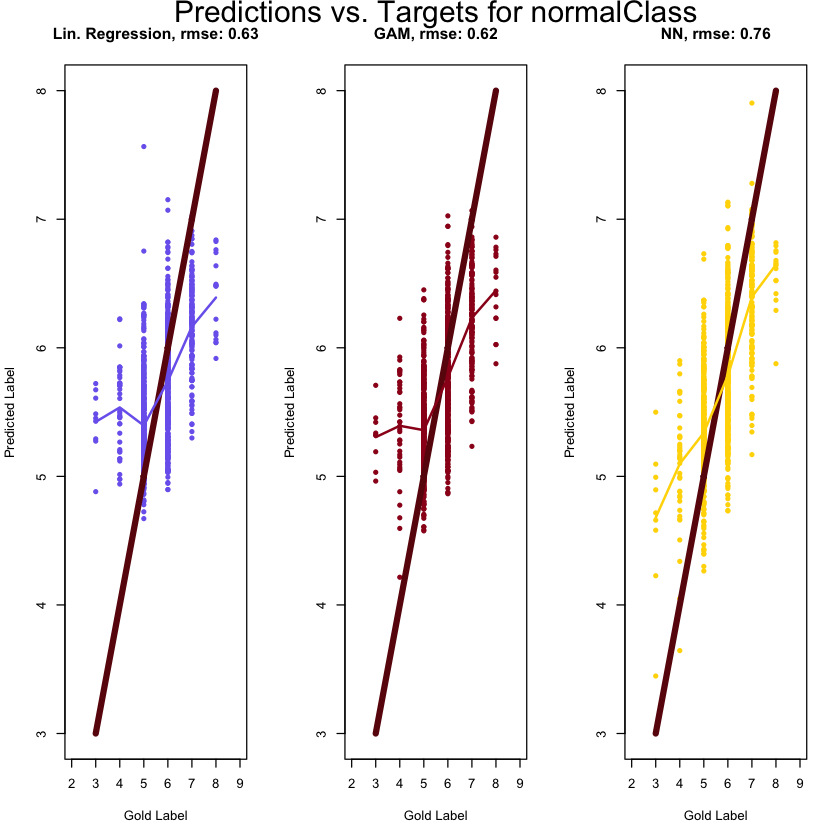

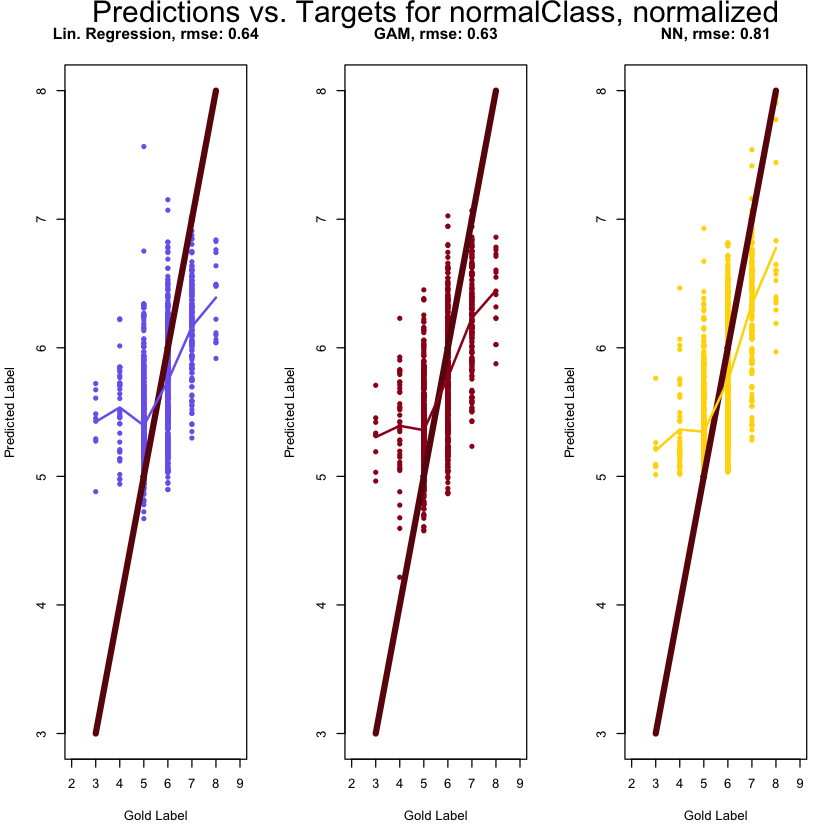

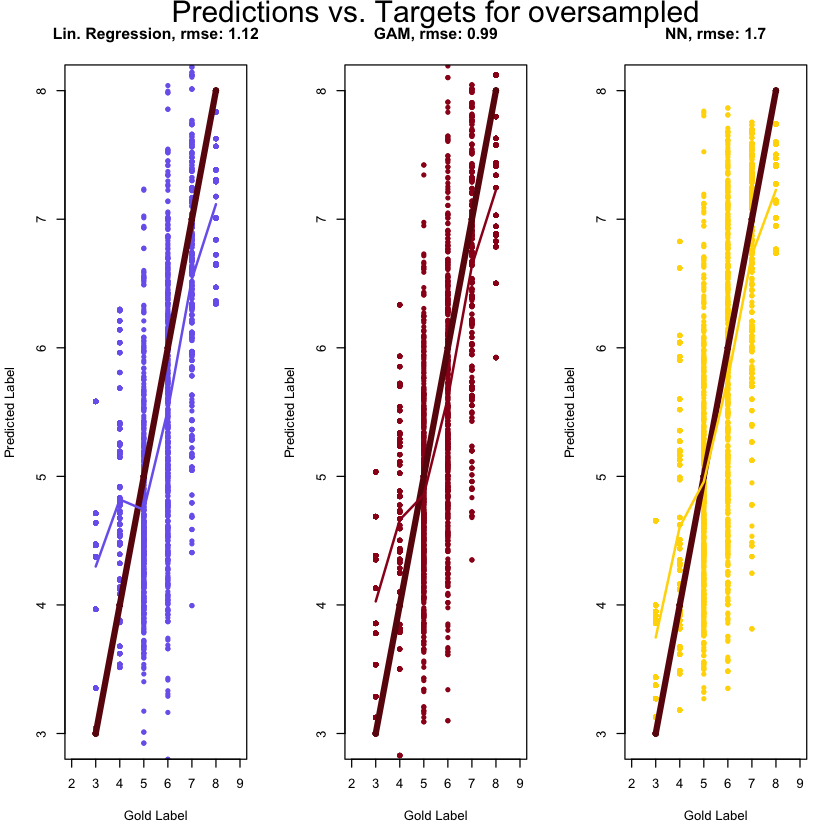

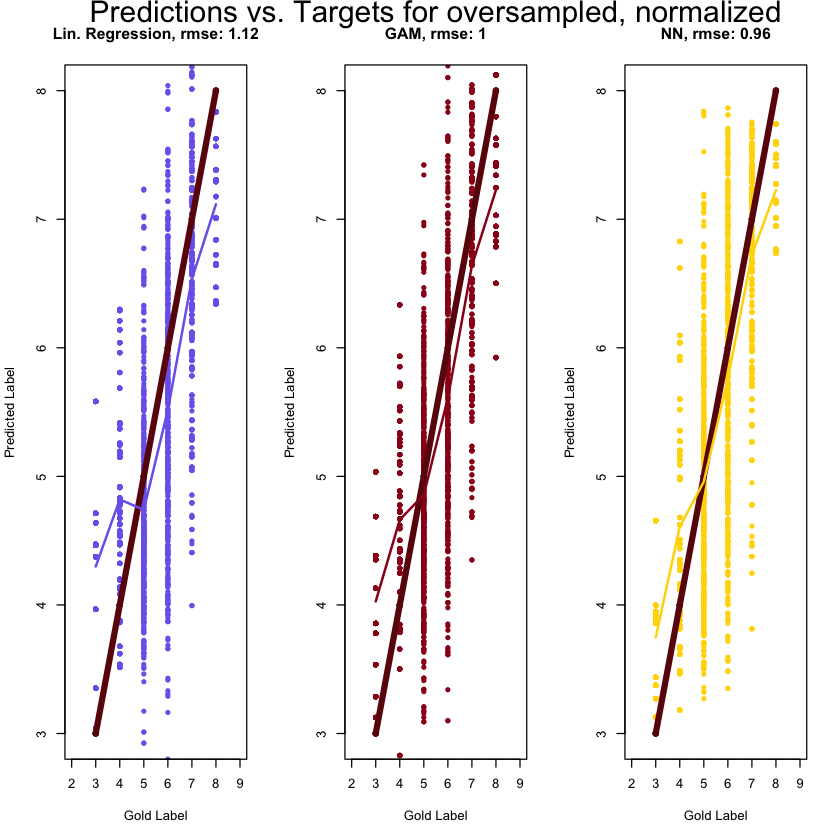

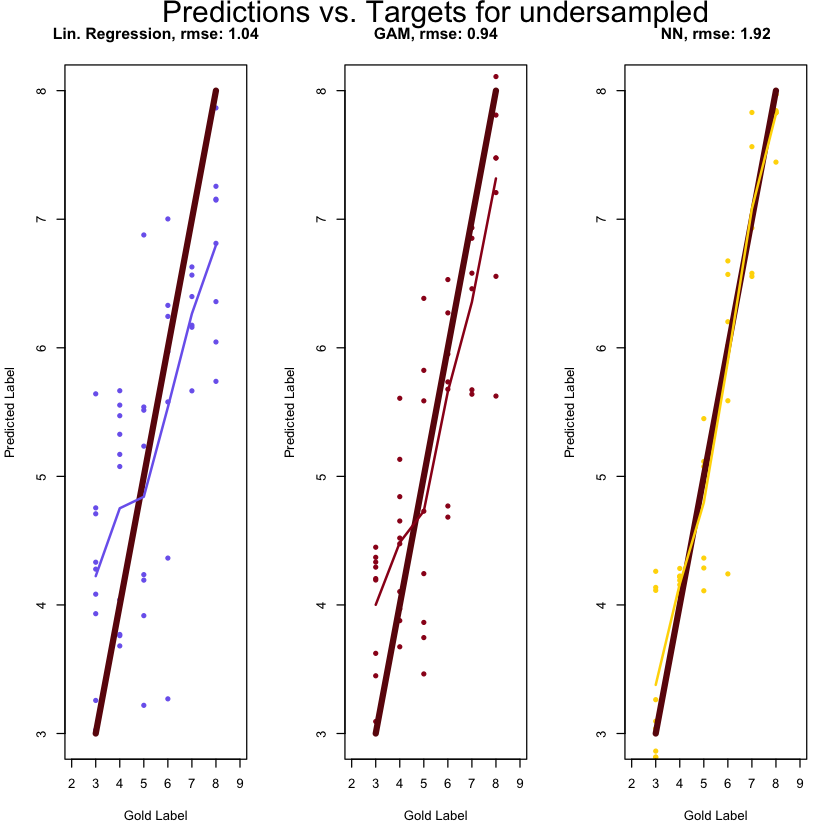

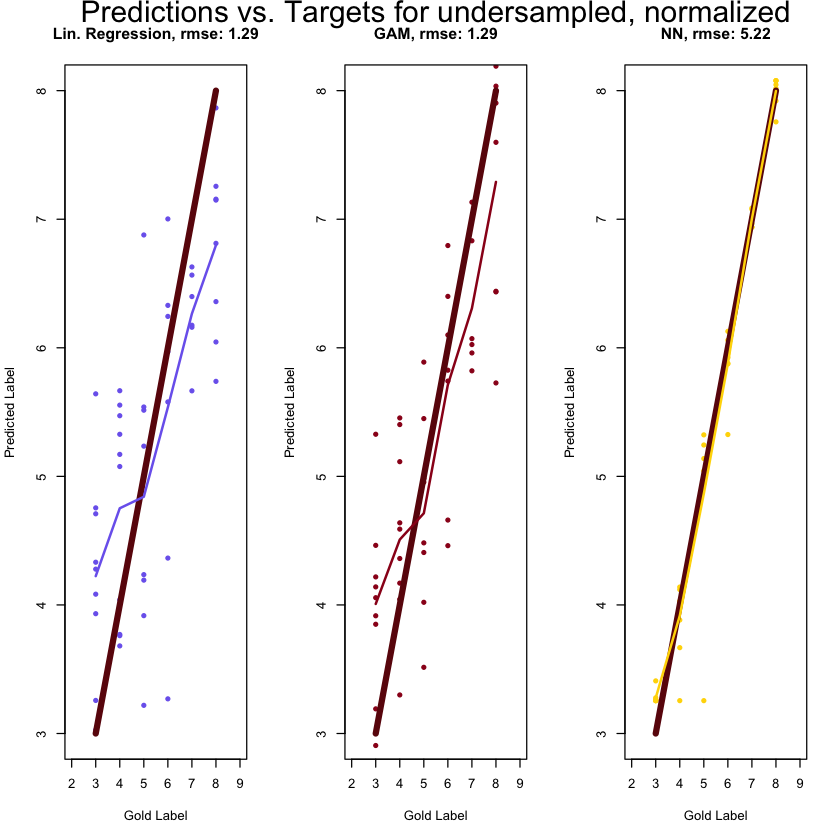

In [131]:
modelColor.gold <- "#6B0D0D"
modelColor.pred <- c("#7B68EE", "#9B111E", "#FFD700")

for(i in 1:length(files)){
    preds.train <- data.frame(gold = train_dfs[[i]]$quality,
                        LR = preds.train.LR[[i]],
                        GAM = preds.train.GAM[[i]],
                        NN = preds.train.NN[[i]])
    preds.train <- preds.train[order(preds.train$gold),]

    pred.means <- aggregate(. ~ gold, data = preds.train, FUN = mean)

    par(mfrow = c(1, 3))

    
    plot(preds.train$gold, preds.train$LR, col = modelColor.pred[1], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("Lin. Regression, rmse:", round(LR[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$LR, col = modelColor.pred[1], lw = 2)

    plot(preds.train$gold, preds.train$GAM, col = modelColor.pred[2], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("GAM, rmse:", round(GAM[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$GAM, col = modelColor.pred[2], lw = 2)

    if(grepl("normalized", files[i])){
        title <- paste("Predictions vs. Targets for ", files[i-1], ", normalized", sep = "")
    }
    else{
        title <- paste("Predictions vs. Targets for ", files[i], sep = "")
    }
    mtext(title, line = 2.56, cex = 1.5)

    plot(preds.train$gold, preds.train$NN, col = modelColor.pred[3], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("NN, rmse:", round(NN[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$NN, col = modelColor.pred[3], lw = 2)
}


